# Part 1

### Demonstrate supervised contrastive learning loss

In [ ]:
!pip install tensorflow
!pip install tensorflow-addons


## Load and Prepare the CIFAR-10 Dataset
CIFAR-10 is a dataset of 60,000 32x32 color images in 10 classes, with 6,000 images per class. We will use TensorFlow to load this dataset and prepare it by normalizing the images.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

def load_and_preprocess_data():
    # Load CIFAR-10 dataset
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    # Normalize pixel values to be between 0 and 1
    train_images, test_images = train_images / 255.0, test_images / 255.0

    return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_and_preprocess_data()


In [ ]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(256)


## Defining the Neural Network Architecture

In [ ]:
from tensorflow.keras import models, layers
import tensorflow_addons as tfa

def create_base_network():
    base_model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization()
    ])
    return base_model

def create_projection_head():
    """Projection head for contrastive learning."""
    projection_head = models.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(32)  # Output size chosen as 32 for the example
    ])
    return projection_head

base_network = create_base_network()
projection_head = create_projection_head()


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


This `SupervisedContrastiveLoss` class in TensorFlow defines a custom loss function that leverages temperature-scaled cosine similarities between embeddings, specifically focusing on contrasting embeddings of different classes. It normalizes embeddings to unit length, computes all pairwise cosine similarities, scales them by a specified temperature, and calculates the loss using log-sum-exp of negative pair similarities to enhance separation between different classes.

In [ ]:
import tensorflow as tf

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.05):
        super().__init__()
        self.temperature = temperature

    def call(self, labels, embeddings):
        # Normalize embeddings to unit length
        embeddings = tf.math.l2_normalize(embeddings, axis=1)

        # Compute all pairwise cosine similarities
        dot_product = tf.matmul(embeddings, embeddings, transpose_b=True)
        similarity = dot_product / self.temperature

        # Create a mask to zero-out self-comparisons (diagonal elements)
        batch_size = tf.shape(embeddings)[0]
        mask = tf.linalg.tensor_diag(tf.ones(batch_size))
        similarity -= mask * 1e9  # Subtract a large number from diagonal elements

        # Convert labels to boolean one-hot encodings
        labels = tf.expand_dims(labels, 1)
        labels_t = tf.transpose(labels)
        mask_positive = tf.equal(labels, labels_t)
        mask_negative = tf.logical_not(mask_positive)

        # Loss for maximizing similarities of positive pairs
        exp_similarities = tf.exp(similarity)
        sum_exp_similarities = tf.reduce_sum(exp_similarities, axis=1)

        exp_positive_similarities = tf.exp(similarity) * tf.cast(mask_positive, tf.float32)
        sum_exp_positive_similarities = tf.reduce_sum(exp_positive_similarities, axis=1)

        # Loss computation: LogSumExp of negatives - LogSumExp of all
        positive_similarities = tf.reduce_sum(similarity * tf.cast(mask_positive, tf.float32), axis=1)
        contrastive_loss = tf.math.log(sum_exp_similarities) - tf.math.log(sum_exp_positive_similarities + 1e-9)
        contrastive_loss = tf.reduce_mean(contrastive_loss)

        return contrastive_loss

# Example use of the loss
loss_function = SupervisedContrastiveLoss(temperature=0.05)


## Configuring the Optimizer and Preparing the Training Loop


In [ ]:
@tf.function  # Use tf.function to compile train_step into a callable TensorFlow graph
def train_step(images, labels, base_network, projection_head, optimizer):
    with tf.GradientTape() as tape:
        features = base_network(images)
        projections = projection_head(features)
        loss = SupervisedContrastiveLoss()(labels, projections)

    gradients = tape.gradient(loss, base_network.trainable_variables + projection_head.trainable_variables)
    optimizer.apply_gradients(zip(gradients, base_network.trainable_variables + projection_head.trainable_variables))
    return loss


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust learning rate

def train_model(train_images, train_labels, base_network, projection_head, optimizer, batch_size=256, epochs=10):
    steps_per_epoch = len(train_images) // batch_size

    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            start = step * batch_size
            end = start + batch_size
            batch_images = train_images[start:end]
            batch_labels = train_labels[start:end]

            loss = train_step(batch_images, batch_labels, base_network, projection_head, optimizer)
            if step % 100 == 0:
                print(f"Step {step}, Loss: {loss.numpy()}")

        print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

# Retrain the model
train_model(train_images, train_labels, base_network, projection_head, optimizer, batch_size=256, epochs=10)


Step 0, Loss: 40.14183807373047
Step 100, Loss: 29.177005767822266
Epoch 1, Loss: 28.769718170166016
Step 0, Loss: 28.73189353942871
Step 100, Loss: 28.602615356445312
Epoch 2, Loss: 28.57394790649414
Step 0, Loss: 28.5709228515625
Step 100, Loss: 28.462331771850586
Epoch 3, Loss: 28.326274871826172
Step 0, Loss: 28.259151458740234
Step 100, Loss: 28.34789276123047
Epoch 4, Loss: 28.291160583496094
Step 0, Loss: 28.239397048950195
Step 100, Loss: 28.152711868286133
Epoch 5, Loss: 28.190567016601562
Step 0, Loss: 28.166675567626953
Step 100, Loss: 28.023357391357422
Epoch 6, Loss: 27.994232177734375
Step 0, Loss: 28.046001434326172
Step 100, Loss: 28.011348724365234
Epoch 7, Loss: 27.878936767578125
Step 0, Loss: 27.931140899658203
Step 100, Loss: 27.888046264648438
Epoch 8, Loss: 27.98436737060547
Step 0, Loss: 27.891542434692383
Step 100, Loss: 27.855926513671875
Epoch 9, Loss: 27.86371612548828
Step 0, Loss: 27.906482696533203
Step 100, Loss: 27.923500061035156
Epoch 10, Loss: 27.750

## Visualization

313/313 [==============================] - 1s 3ms/step


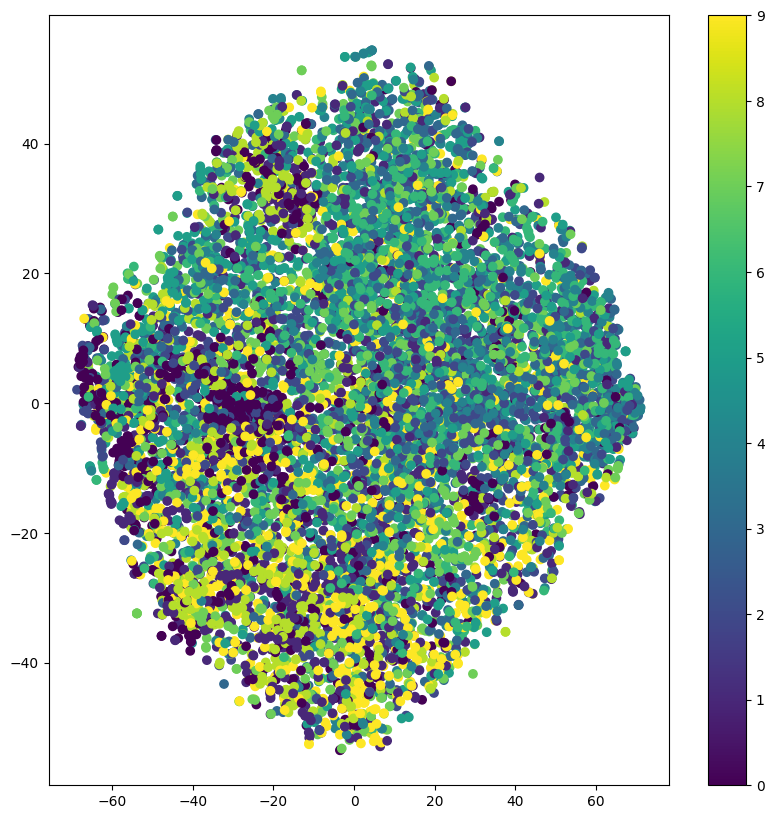

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(base_network, images, labels):
    features = base_network.predict(images)
    tsne = TSNE(n_components=2)
    transformed_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c=labels.flatten(), cmap='viridis')
    plt.colorbar(scatter)
    plt.show()

# Visualize embeddings for test images
visualize_embeddings(base_network, test_images, test_labels)


In [ ]:
import tensorflow as tf

# Define model, optimizer, and loss
model = create_base_network()  # Assuming this function returns a compiled model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = SupervisedContrastiveLoss(temperature=0.05)

@tf.function
def train_step(images, labels, model, optimizer):
    with tf.GradientTape() as tape:
        embeddings = model(images, training=True)
        loss = loss_function(labels, embeddings)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
for epoch in range(10):  # Number of epochs
    total_loss = 0
    for images, labels in train_dataset:  # Assuming train_dataset is properly batched
        loss = train_step(images, labels, model, optimizer)
        total_loss += loss.numpy()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataset)}")


Epoch 1, Loss: 25.081535563176992
Epoch 2, Loss: 24.96313818133607
Epoch 3, Loss: 24.931501923775187
Epoch 4, Loss: 24.916083666743063
Epoch 5, Loss: 24.90125412843665
Epoch 6, Loss: 24.895446475671264
Epoch 7, Loss: 24.889789882971314
Epoch 8, Loss: 24.883560219589544
Epoch 9, Loss: 24.880378616099456
Epoch 10, Loss: 24.884461081757838


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

Epoch 1, Loss: 24.878702261009995
Epoch 2, Loss: 24.87246623331187
Epoch 3, Loss: 24.86726428051384
Epoch 4, Loss: 24.857746085342097
Epoch 5, Loss: 24.83997645670054
Epoch 6, Loss: 24.758226161100428
Epoch 7, Loss: 24.678585597446986
Epoch 8, Loss: 24.672889553770727
Epoch 9, Loss: 24.68133409655824
Epoch 10, Loss: 24.697733227087525


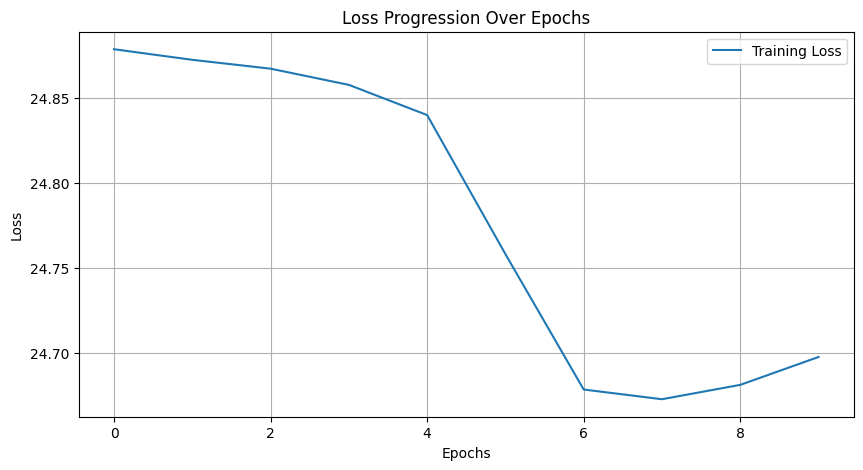

In [ ]:
#Prepare to track loss and optionally embeddings
epoch_losses = []
all_labels = []
all_embeddings = []

@tf.function
def train_step(images, labels, model, optimizer):
    with tf.GradientTape() as tape:
        embeddings = model(images, training=True)
        loss = loss_function(labels, embeddings)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, embeddings

# Training loop
for epoch in range(10):  # Number of epochs
    total_loss = 0
    for images, labels in train_dataset:  # Assuming train_dataset is properly batched
        loss, embeddings = train_step(images, labels, model, optimizer)
        total_loss += loss.numpy()

        # Optionally, collect embeddings and labels for visualization every 5 epochs
        if epoch % 5 == 0:
            all_embeddings.append(embeddings.numpy())
            all_labels.append(labels.numpy())

    epoch_loss = total_loss / len(train_dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")

# Convert lists to arrays for visualization
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Progression Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



# Part 2

## Transfer learning on various modalities

## Image

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
import tensorflow_datasets as tfds

# Load dataset
(train_ds, val_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

# Prepare data
size = (160, 160)  # MobileNetV2 expects images of size 160x160
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))

train_ds = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteUVRCK0/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(input_shape=(160, 160, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the classification head
model = Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Display the model's architecture
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)


Epoch 1/5
582/582 [==============================] - 287s 489ms/step - loss: 0.4864 - accuracy: 0.7615 - val_loss: 0.4292 - val_accuracy: 0.8065
Epoch 2/5
582/582 [==============================] - 294s 505ms/step - loss: 0.4256 - accuracy: 0.8036 - val_loss: 0.4099 - val_accuracy: 0.8177
Epoch 3/5
582/582 [==============================] - 283s 486ms/step - loss: 0.4102 - accuracy: 0.8123 - val_loss: 0.4017 - val_accuracy: 0.8218
Epoch 4/5
582/582 [==============================] - 273s 469ms/step - loss: 0.4015 - accuracy: 0.8173 - val_loss: 0.3973 - val_accuracy: 0.8255
Epoch 5/5
582/582 [==============================] - 289s 496ms/step - loss: 0.3955 - accuracy: 0.8207 - val_loss: 0.3947 - val_accuracy: 0.8259


In [ ]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model (necessary for these changes to take effect)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Model summary to see which layers are trainable
model.summary()


Number of layers in the base model:  154
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [ ]:
# Continue training the model
fine_tune_epochs = 5
total_epochs = 5 + fine_tune_epochs  # previous + fine-tune

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Epoch 5/10
582/582 [==============================] - 413s 697ms/step - loss: 0.5059 - accuracy: 0.7710 - val_loss: 0.4714 - val_accuracy: 0.8020
Epoch 6/10
582/582 [==============================] - 399s 685ms/step - loss: 0.3201 - accuracy: 0.8618 - val_loss: 0.3934 - val_accuracy: 0.8375
Epoch 7/10
582/582 [==============================] - 395s 679ms/step - loss: 0.2323 - accuracy: 0.9099 - val_loss: 0.3560 - val_accuracy: 0.8506
Epoch 8/10
582/582 [==============================] - 425s 730ms/step - loss: 0.1695 - accuracy: 0.9459 - val_loss: 0.3422 - val_accuracy: 0.8549
Epoch 9/10
582/582 [==============================] - 428s 736ms/step - loss: 0.1219 - accuracy: 0.9718 - val_loss: 0.3393 - val_accuracy: 0.8568
Epoch 10/10
582/582 [==============================] - 398s 684ms/step - loss: 0.0856 - accuracy: 0.9869 - val_loss: 0.3418 - val_accuracy: 0.8622


## Video

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2

# Load an image dataset
ds, ds_info = tfds.load('mnist', split='train[:10%]', with_info=True, as_supervised=True)

# Function to simulate video data from images and convert grayscale to RGB
def simulate_video_and_convert_to_rgb(image, label):
    # Convert grayscale to RGB
    image = tf.image.grayscale_to_rgb(image)
    # Resize image to match MobileNetV2 input
    image = tf.image.resize(image, (96, 96))  # Reduced from 224 for faster processing
    # Stack the image to simulate a video clip
    video = tf.stack([image] * 10, axis=0)  # Use 10 frames
    return video, label

# Preprocess and batch the data
ds = ds.map(simulate_video_and_convert_to_rgb).batch(4).prefetch(tf.data.experimental.AUTOTUNE)

# Define the model using MobileNetV2
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = Sequential([
    TimeDistributed(base_model, input_shape=(10, 96, 96, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(50),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(ds, epochs=5)


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 3, 3, 1280)    2257984   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 1280)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 50)                266200    
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 2524694 (9.63 MB)
Trainable params: 266710 (1.02 MB)
Non-trainable params: 2257984 (8.61 MB)
________________

In [ ]:
# Assuming there is a test set prepared similarly to the training set
test_ds, _ = tfds.load('mnist', split='test[:10%]', with_info=True, as_supervised=True)
test_ds = test_ds.map(simulate_video_and_convert_to_rgb).batch(4).prefetch(tf.data.experimental.AUTOTUNE)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


250/250 [==============================] - 55s 203ms/step - loss: 0.2068 - accuracy: 0.9350
Test Loss: 0.2068014293909073, Test Accuracy: 0.9350000023841858


## Audio

In [ ]:
!pip install pydub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import numpy as np
import requests
from io import BytesIO

# Load YAMNet from TensorFlow Hub
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Function to download and load an audio file
def load_audio_from_url(url, sample_rate=16000):
    data = requests.get(url).content
    audio, sr = librosa.load(BytesIO(data), sr=sample_rate)
    return audio

# Predict audio events using YAMNet
def predict_audio_events(audio):
    # Ensure the audio is 1D
    audio = np.reshape(audio, -1)  # Flatten the array to 1D
    # Run the model
    scores, embeddings, spectrogram = yamnet_model(audio)
    # Apply softmax to get probabilities
    probabilities = tf.nn.softmax(scores)
    return probabilities.numpy(), spectrogram.numpy()

# URL of an example audio file
audio_url = "https://storage.googleapis.com/audioset/speech_whistling2.wav"

# Load and preprocess the audio
audio = load_audio_from_url(audio_url)

# Predict events in the audio
probabilities, spectrogram = predict_audio_events(audio)

# Get class names from YAMNet labels file
class_map_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv'
response = requests.get(class_map_url)
class_names = np.genfromtxt(BytesIO(response.content), delimiter=',', skip_header=1, usecols=2, dtype=str)

# Extract top 5 predictions
top_5_indices = np.argsort(probabilities[0])[::-1][:5]

print("Top 5 predictions:")
for index in top_5_indices:
    print(f"{class_names[index]}: {probabilities[0, index] * 100:.2f}%")



Top 5 predictions:
Speech: 0.51%
"Narration: 0.20%
Clicking: 0.20%
Speech synthesizer: 0.20%
Conversation: 0.19%


## Text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Load pre-trained Universal Sentence Encoder from TensorFlow Hub
hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.KerasLayer(hub_url, input_shape=[], dtype=tf.string, trainable=True)

# Build the model
model = tf.keras.Sequential([
    embed,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Load the IMDB reviews dataset
train_data, validation_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]'),
    as_supervised=True)

# Train the model
model.fit(train_data.batch(512), epochs=5, validation_data=validation_data.batch(512))

# Evaluate the model
test_data = tfds.load(name="imdb_reviews", split='test', as_supervised=True)
model.evaluate(test_data.batch(512))


Epoch 1/5
30/30 [==============================] - 155s 5s/step - loss: 0.5695 - accuracy: 0.7749 - val_loss: 0.4319 - val_accuracy: 0.8213
Epoch 2/5
30/30 [==============================] - 150s 5s/step - loss: 0.2849 - accuracy: 0.9002 - val_loss: 0.2935 - val_accuracy: 0.8822
Epoch 3/5
30/30 [==============================] - 150s 5s/step - loss: 0.1037 - accuracy: 0.9743 - val_loss: 0.3022 - val_accuracy: 0.8867
Epoch 4/5
30/30 [==============================] - 154s 5s/step - loss: 0.0332 - accuracy: 0.9953 - val_loss: 0.3634 - val_accuracy: 0.8730
Epoch 5/5
49/49 [==============================] - 28s 575ms/step - loss: 0.3514 - accuracy: 0.8818


[0.3513953983783722, 0.8817999958992004]

# Part 3

### Zero shot transfer learning with CLIP model


## Setup the Environment

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 608.2 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-s07oc94_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-s07oc94_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

## Import Libraries and Load the CLIP Model

In [ ]:
import torch
import clip
from PIL import Image
import requests
from io import BytesIO

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 222MiB/s]


## Prepare Inputs for Zero-Shot Classification
For zero-shot learning with CLIP, We'll need to specify some text prompts that describe potential categories or characteristics of the images you want to classify.

CLIP will compare these descriptions against the images to find the best match without having seen examples of these categories during training.

In [ ]:
# Define text prompts
text_prompts = ["a photo of a dog", "a photo of a cat", "a photo of a banana"]

# Convert text prompts to tensors
text_inputs = clip.tokenize(text_prompts).to(device)

# Let's use a different example image from the web
image_url = "https://images.unsplash.com/photo-1574158622682-e40e69881006?ixlib=rb-1.2.1&auto=format&fit=crop&w=700&q=60"
response = requests.get(image_url)

# Check if the image was fetched successfully
if response.status_code == 200:
  try:
        # Attempt to open the image directly from the response content
    image = Image.open(BytesIO(response.content))

    image.show()  # Display the image to confirm it's loaded correctly

        # Preprocess the image and prepare for the model
    image_input = preprocess(image).unsqueeze(0).to(device)
  except IOError:
    print("Unable to open the image. There might be an issue with the image file.")
else:
  print("Failed to fetch image. Status code:", response.status_code)


## Perform Zero-Shot Classification with CLIP

Now that we have our image and text inputs ready, we can use CLIP to perform zero-shot classification. This involves comparing the image to each of our text descriptions to see which description best matches the image according to the model.

In [ ]:
# Calculate features for the image and text inputs
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Compute the similarity between the image and text features
logits_per_image, logits_per_text = model(image_input, text_inputs)
probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

# Display the top classification result
top_prediction = text_prompts[probs.argmax()]
print(f"Top prediction: {top_prediction}")


Top prediction: a photo of a cat


In [ ]:
!pip install tensorflow_datasets


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)


TensorFlow version: 2.15.0
TensorFlow Hub version: 0.16.1


## Load the Pre-trained Model

We will use the BigTransfer (BiT) model from TensorFlow Hub. This model has been pre-trained on a large dataset and can be fine-tuned to adapt to your specific dataset. Let's load the BiT model suited for transfer learning:

In [ ]:
# URL of the BiT model pre-trained on ImageNet21k
BIT_MODEL_URL = "https://tfhub.dev/google/bit/m-r50x1/1"

# Load the pre-trained model from TensorFlow Hub
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly loaded
    tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
    # Hub KerasLayer wraps the model loaded from TFHub
    hub.KerasLayer(BIT_MODEL_URL, trainable=True),
    # Add a new classification layer for transfer learning
    tf.keras.layers.Dense(5, activation='softmax')
])



# Compile the model with SparseCategoricalCrossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23500352  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23510597 (89.69 MB)
Trainable params: 23510597 (89.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Prepare the Dataset
We'll use the flowers dataset available from TensorFlow datasets.

In [ ]:
# Load example dataset
(train_ds, validation_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Function to preprocess images and ensure labels are integers
def preprocess_image(image, label):
    image = tf.image.resize(image, [256, 256])  # Resize to match the model's expected input
    image = image / 255.0  # Normalize pixel values
    return image, tf.cast(label, tf.int32)  # Ensure labels are integers

# Apply preprocessing to dataset
train_ds = train_ds.map(preprocess_image).batch(32)
validation_ds = validation_ds.map(preprocess_image).batch(32)



## Train the Model
Now that the model and dataset are ready, it's time to train the model. This involves fine-tuning the pre-trained BigTransfer (BiT) model on your dataset.


In [ ]:
# Setup the training parameters
EPOCHS = 10  # You can adjust the number of epochs based on your needs

# Start training
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds
)


Epoch 1/10
92/92 [==============================] - 127s 876ms/step - loss: 2.6914 - accuracy: 0.2384 - val_loss: 1.5696 - val_accuracy: 0.2752
Epoch 2/10
92/92 [==============================] - 74s 801ms/step - loss: 1.4824 - accuracy: 0.3501 - val_loss: 1.2956 - val_accuracy: 0.4850
Epoch 3/10
92/92 [==============================] - 74s 801ms/step - loss: 1.1063 - accuracy: 0.5381 - val_loss: 1.0617 - val_accuracy: 0.5627
Epoch 4/10
92/92 [==============================] - 74s 803ms/step - loss: 0.9713 - accuracy: 0.6029 - val_loss: 0.8882 - val_accuracy: 0.6485
Epoch 5/10
92/92 [==============================] - 74s 803ms/step - loss: 0.8563 - accuracy: 0.6587 - val_loss: 0.8837 - val_accuracy: 0.6512
Epoch 6/10
92/92 [==============================] - 74s 804ms/step - loss: 0.7706 - accuracy: 0.7003 - val_loss: 0.7692 - val_accuracy: 0.7098
Epoch 7/10
92/92 [==============================] - 70s 756ms/step - loss: 0.7024 - accuracy: 0.7170 - val_loss: 0.6247 - val_accuracy: 0.738

## Evaluate the Model

* Training Loss and Accuracy: The training loss decreased from 2.6914 to 0.5343, and the training accuracy improved from 23.84% to 79.60%. This suggests that the model is learning effectively from the training data.

* Validation Loss and Accuracy: The validation loss started at 1.5696 and decreased to 0.6097, while the validation accuracy improved from 27.52% to 77.38%. The improvement in validation metrics indicates that the model is generalizing well to new data.

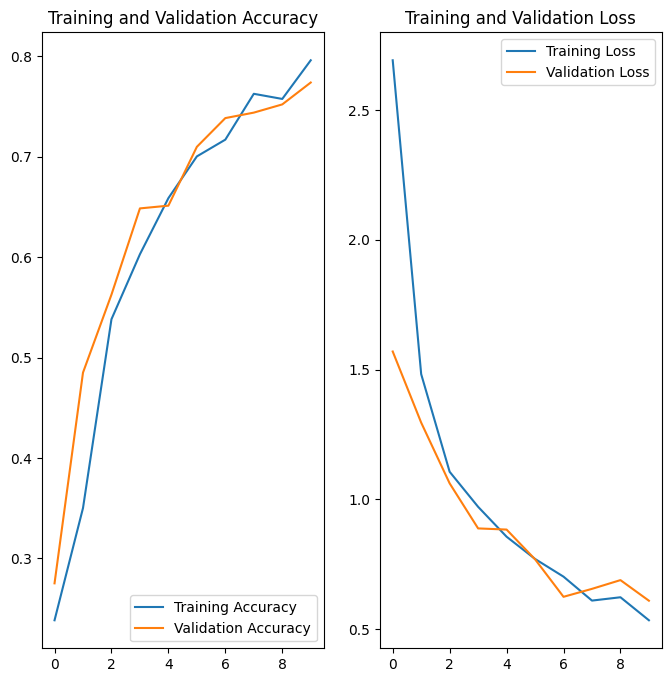

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
